# 0. Library

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping

# 1. Prep
- 시드 고정, 시퀀스 생성, 전처리 등

In [2]:
# 시드 고정
plt.rcParams["font.family"] = "Malgun Gothic"
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# 시퀀스 데이터 생성 함수
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# 데이터 전처리 함수 
def prepare_data(df, window_size=5):
    target_column = 'USD_KRW 종가'
    columns_to_drop = ['date', target_column]

    features = df.drop(columns=columns_to_drop).values
    target = df[target_column].values.reshape(-1, 1)

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features_scaled = scaler_x.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target)

    X, y = create_sequences(features_scaled, target_scaled, window_size)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    return X_train, X_test, y_train, y_test, scaler_y

# 2. Modeling

In [4]:
# 모델 정의 함수 
def build_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_lstm(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_gru(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        GRU(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# 모델 학습 및 예측

def train_models(df, window_size=5, epochs=1000, batch_size=16):
    X_train, X_test, y_train, y_test, scaler_y = prepare_data(df, window_size)
    input_shape = (X_train.shape[1], X_train.shape[2])
    y_test_inv = scaler_y.inverse_transform(y_test)
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # 모델 생성 함수들을 미리 정의
    model_builders = {
        'LSTM': build_lstm,
        'GRU': build_gru,
        'CNN-LSTM': build_cnn_lstm,
        'CNN-GRU': build_cnn_gru,
    }

    results = {}
    models = {}

    # 모델 인스턴스 생성 및 학습
    for name, builder in model_builders.items():
        model = builder(input_shape)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
        models[name] = model  # 모델 저장

    # 예측 및 평가 (retracing 최소화)
    for name, model in models.items():
        pred = model.predict(X_test, verbose=0)  # retracing 줄이기
        pred = scaler_y.inverse_transform(pred)
        mse = mean_squared_error(y_test_inv, pred)
        mape = mean_absolute_percentage_error(y_test_inv, pred) * 100
        results[name] = {'metrics': {'mse': mse, 'mape': mape}, 'predictions': pred}

    return results, y_test_inv

In [5]:
def run_experiments(datasets, window_size=5, epochs=1000, batch_size=16):
    all_results = {}
    for name, df in datasets.items():
        print(f"\n===== Running for dataset: {name} =====")
        results, y_test_inv = train_models(df, window_size, epochs, batch_size)
        all_results[name] = {'models': results, 'y_test_inv': y_test_inv}
    return all_results

# 결과 시각화 함수
def plot_predictions(y_test_inv, predictions, title):
    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label='Actual')
    for model_name, data in predictions.items():
        plt.plot(data['predictions'], label=model_name)
    plt.title(f'{title} - 모델 예측 결과')
    plt.xlabel('Time Step')
    plt.ylabel('USD_KRW 종가')
    plt.legend()
    plt.show()

# 평가 결과 정리 함수
def summarize_results(experiment_results):
    rows = []
    for dataset_name, result in experiment_results.items():
        for model_name, model_data in result['models'].items():
            mse = model_data['metrics']['mse']
            mape = model_data['metrics']['mape']
            rows.append({
                '데이터셋': dataset_name,
                '모델명': model_name,
                'MSE': mse,
                'MAPE (%)': mape
            })
    return pd.DataFrame(rows)

# 3. Result

In [6]:
base_path = r"C:\Users\james\J_Data_Lab\Project-FXCast"
df_paths = {
    'w/o_sentiment': f"{base_path}\\data\\df_investing2.csv",
    'news_3_class': f"{base_path}\\modeling_data\\news_3class_all.csv",
    'news_3_class_95_score': f"{base_path}\\modeling_data\\news_3class_95_score.csv",
    'news_3_class_90_score': f"{base_path}\\modeling_data\\news_3class_90_score.csv",
    'news_2_class': f"{base_path}\\modeling_data\\news_2class_all.csv",
    'news_2_class_95_score': f"{base_path}\\modeling_data\\news_2class_95_score.csv",
    'news_2_class_90_score': f"{base_path}\\modeling_data\\news_2class_90_score.csv",
    'comment_score': f"{base_path}\\modeling_data\\comment_score.csv",
    'comment_score_90_score': f"{base_path}\\modeling_data\\comment_score_0.9.csv",
    'comment_with_count': f"{base_path}\\modeling_data\\comment_score_with_count.csv",
    'comment_90_score_with_count': f"{base_path}\\modeling_data\\comment_score_0.9_with_count.csv",
    'news_2_class_and_comment': f"{base_path}\\modeling_data\\news_2class_all_comment_all.csv",
    'news_3_class_and_comment': f"{base_path}\\modeling_data\\news_3class_all_comment_all.csv",
    'news_3_class_and_comment_count': f"{base_path}\\modeling_data\\news_3class_all_comment_all_with_count.csv",
    'news_2_class_and_comment_count': f"{base_path}\\modeling_data\\news_2class_all_comment_all_with_count.csv",
}

datasets = {}
for name, path in df_paths.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    datasets[name] = df

# 실험 실행
results = run_experiments(datasets)

# 결과 요약 테이블 생성 및 출력
summary_df = summarize_results(results)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


===== Running for dataset: w/o_sentiment =====

===== Running for dataset: news_3_class =====

===== Running for dataset: news_3_class_95_score =====

===== Running for dataset: news_3_class_90_score =====

===== Running for dataset: news_2_class =====

===== Running for dataset: news_2_class_95_score =====

===== Running for dataset: news_2_class_90_score =====

===== Running for dataset: comment_score =====

===== Running for dataset: comment_score_90_score =====

===== Running for dataset: comment_with_count =====

===== Running for dataset: comment_90_score_with_count =====

===== Running for dataset: news_2_class_and_comment =====

===== Running for dataset: news_3_class_and_comment =====

===== Running for dataset: news_3_class_and_comment_count =====

===== Running for dataset: news_2_class_and_comment_count =====


In [7]:
print("===== 결과 =====")
summary_df

===== 결과 =====


,데이터셋,모델명,MSE,MAPE (%)
0,w/o_sentiment,LSTM,154.582199,0.862627
1,w/o_sentiment,GRU,391.894196,1.414386
2,w/o_sentiment,CNN-LSTM,1231.639771,2.515150
3,w/o_sentiment,CNN-GRU,732.919067,1.890148
4,news_3_class,LSTM,490.783325,1.627882
5,news_3_class,GRU,71.056755,0.575950
6,news_3_class,CNN-LSTM,1203.929810,2.541264
7,news_3_class,CNN-GRU,501.083466,1.615509
8,news_3_class_95_score,LSTM,383.701355,1.412983
9,news_3_class_95_score,GRU,99.044571,0.679252


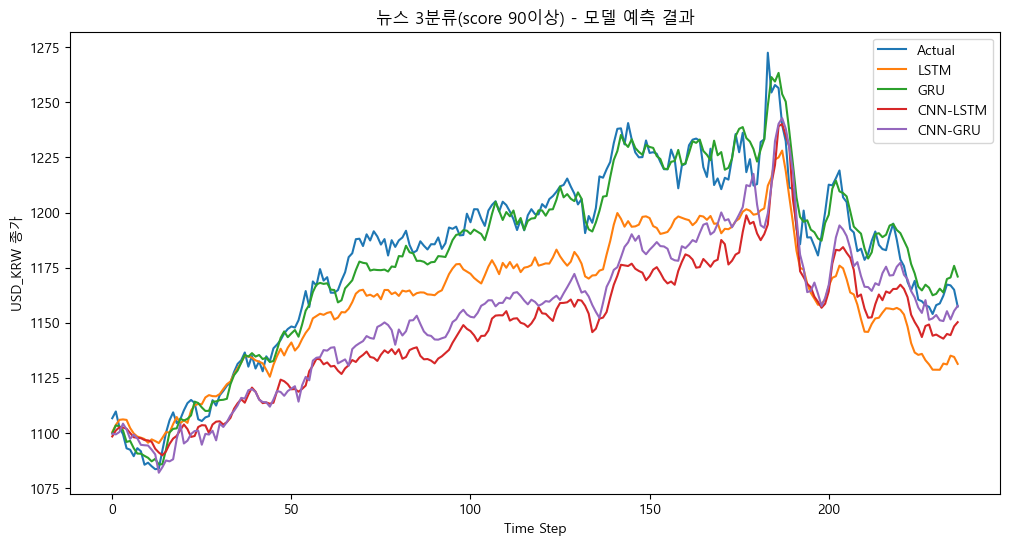

In [8]:
# best 결과 시각화
plot_predictions(results['news_3_class_90_score']['y_test_inv'], results['news_3_class_90_score']['models'], title='뉴스 3분류(score 90이상)')